In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import re
# from sklearn.model_selection import train_test_split

%matplotlib inline

In [158]:
def make_numeric(x):
    try:
        return float(re.sub(r'[^\d.]+', '', str(x)))
    except:
        return x

In [159]:
df = pd.read_csv('pga_stats.csv', low_memory=False)

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17648 entries, 0 to 17647
Columns: 1168 entries, Player Name to SG_Putting_TOTAL PUTTS GAINED
dtypes: float64(998), int64(1), object(169)
memory usage: 157.3+ MB


In [161]:
df = df.dropna(thresh=1000)
df = df.dropna(thresh=1500, axis=1)

In [162]:
df.loc[:,df.dtypes == object] = df.loc[:,df.dtypes == object].applymap(make_numeric)
df.loc[:,df.dtypes == object] = df.loc[:,df.dtypes == object].applymap(lambda df:  0 if df=='E' else df)
df = df.fillna(0)

In [163]:
players = df.loc[:,'Player Name']
df = df.drop('Player Name', axis=1)

In [164]:
# Drop Object Columns that did not convert
df = df.drop(df.loc[:,df.dtypes == object], axis=1)

In [165]:
target = df[['All-Around_Ranking_TOTAL', 'Year']]

In [189]:
feature = df[df.columns[~df.columns.str.contains('par|rank|rtp|score|birdie|ball_striking|total_driving|rounds|total putts|round|sg:|sg_',case=False)]]

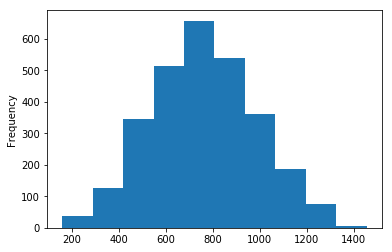

In [190]:
target['All-Around_Ranking_TOTAL'].plot('hist')

In [191]:
feature_train = feature[~feature['Year'].isin([2018])]
target_train = target[~target['Year'].isin([2018])]['All-Around_Ranking_TOTAL']

feature_test = feature[feature['Year'].isin([2018])]
target_test = target[target['Year'].isin([2018])]['All-Around_Ranking_TOTAL']

In [216]:
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1)

In [217]:
rfr.fit(feature_train, target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [218]:
target_predict = rfr.predict(feature_test)

In [219]:
r2_score(target_test, target_predict)

0.6188009797149299

In [220]:
np.sqrt(mean_squared_error(target_test, target_predict))

146.31612816834706

In [221]:
feature_importance_df = pd.DataFrame({'feature': feature_train.columns, 'importance': rfr.feature_importances_})

In [222]:
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

In [223]:
def plot_feature_importances(df, threshold = 0.7):
    """
    Plots 15 most important feature and the cumulative importance of feature.
    Prints the number of feature needed to reach threshold cumulative importance.

    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances

    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column

    """

    #plt.rcParams['font.size'] = 18

    # Sort feature according to importance
    df = df.sort_values('importance', ascending = False).reset_index()

    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of feature'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();

    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d feature required for %0.2f of cumulative importance' % (importance_index + 1, threshold))

    return df

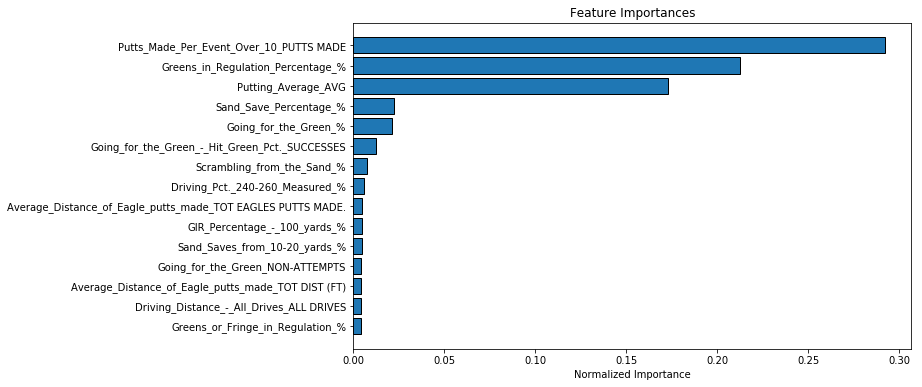

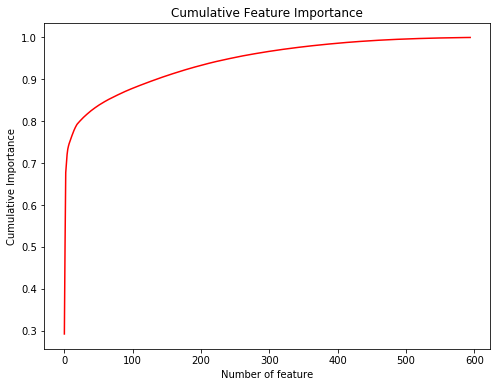

5 feature required for 0.70 of cumulative importance


,index,feature,importance,importance_normalized,cumulative_importance
0,513,Putts_Made_Per_Event_Over_10_PUTTS MADE,0.291935,0.291935,0.291935
1,3,Greens_in_Regulation_Percentage_%,0.212493,0.212493,0.504429
2,26,Putting_Average_AVG,0.172811,0.172811,0.677240
3,6,Sand_Save_Percentage_%,0.022517,0.022517,0.699757
4,343,Going_for_the_Green_%,0.020973,0.020973,0.720730
5,347,Going_for_the_Green_-_Hit_Green_Pct._SUCCESSES,0.012637,0.012637,0.733367
6,156,Scrambling_from_the_Sand_%,0.007260,0.007260,0.740627
7,168,Driving_Pct._240-260_Measured_%,0.005905,0.005905,0.746532
8,224,Average_Distance_of_Eagle_putts_made_TOT EAGLE...,0.004826,0.004826,0.751358
9,65,GIR_Percentage_-_100_yards_%,0.004690,0.004690,0.756048


In [224]:
# In the blog show the original feature importance without removing columns and explain the process of removing them

plot_feature_importances(feature_importance_df)

In [225]:
results = pd.merge(target_test.to_frame(), players.to_frame(), left_index=True, right_index=True, how='left')

In [226]:
results = results.reset_index(drop=True)

In [227]:
results = pd.concat([results, pd.Series(target_predict)], axis=1)

In [228]:
results.columns = ['2018 Rank Score', 'Player Name', '2018 Rank Score Predict']

In [229]:
results[['2018 Rank Score', '2018 Rank Score Predict']] = results[['2018 Rank Score', '2018 Rank Score Predict']].astype(int)

In [230]:
results = results.set_index('Player Name')

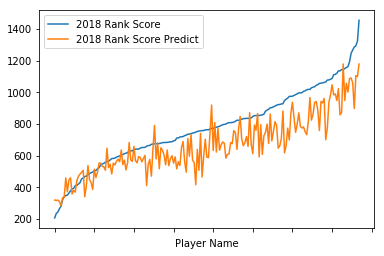

In [231]:
results.sort_values('2018 Rank Score').plot()

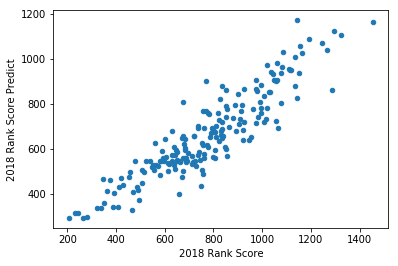

In [208]:
results.sort_values('2018 Rank Score').plot(x='2018 Rank Score', y='2018 Rank Score Predict', kind='scatter')

In [209]:
results['Error'] = np.abs(results['2018 Rank Score'] - results['2018 Rank Score Predict'])

In [210]:
results.sort_values('2018 Rank Score')

,2018 Rank Score,2018 Rank Score Predict,Error
Player Name,,,
Dustin Johnson,206,294,88
Tommy Fleetwood,234,317,83
Justin Thomas,243,317,74
Rickie Fowler,264,295,31
Justin Rose,280,296,16
Hideki Matsuyama,321,336,15
Brooks Koepka,340,337,3
Rafa Cabrera Bello,347,469,122
Bryson DeChambeau,350,362,12


In [188]:
results.sort_values('Error', ascending=False)

,2018 Rank Score,2018 Rank Score Predict,Error
Player Name,,,
Hunter Mahan,748,441,307
Wesley Bryan,1143,891,252
Andrew Yun,1455,1216,239
Brice Garnett,926,701,225
Ben Silverman,922,702,220
Jason Dufner,1028,813,215
J.T. Poston,659,446,213
Robert Streb,1286,1074,212
Nicholas Lindheim,948,737,211
